### Cab-Driver Agent

In [ ]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time
# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [ ]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [ ]:
Time_matrix[1,2,:,6]

array([7., 7., 7., 7., 7., 7., 4., 4., 4., 4., 4., 4., 2., 2., 2., 2., 2.,
       2., 8., 8., 8., 8., 8., 8.])

#### Tracking the state-action pairs for checking convergence


In [ ]:
def Q_state(state):
    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [ ]:
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

In [ ]:
def initialise_tracking_states(): 
    samvalues = [((3,0,2),(3,1)),((1,6,3),(2,3)),((2,2,2),(3,2))] 
    #select any 4 Q-values 
    for q_value in samvalues: 
        state = Q_state(q_value[0]) 
        action = q_value[1] 
        states_track[state][action] = []

In [ ]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [ ]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01       
        self.epsilon_max = 1
        self.epsilon_decay =0.99 
        self.epsilon_min = 0.01
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        
        # hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))

        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state):
    # Write your code here:        
        poss_index, actions = env.requests(state)        
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       
        if np.random.rand() <= self.epsilon_max:
            # explore: choose a random action from all possible actions            
            action = random.choice(actions)
            return action
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state_encode = env.state_encod_arch1(state)
            state_batch = state_encode.reshape(1, self.state_size)
            q_value = self.model.predict(state_batch)
            qvalue = [q_value[0][index] for index in poss_index]
            #print("poss_index", poss_index, " actions ", actions, " state ",state)
            if not poss_index:
                return actions[0]
            else:
                index = np.argmax(qvalue)            
                return actions[index]     
     
        
    def append_sample(self, state, action, reward, next_state, done):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, done))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))# write here
            update_input = np.zeros((self.batch_size, self.state_size)) # write here
            
            actions, rewards, terminals = [], [],[]
            
            for i in range(self.batch_size):
                state, action, reward, next_state, terminal = mini_batch[i]
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                update_output[i] = next_state
                terminals.append(terminal)
                
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
             
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
                
            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):                
                if terminals[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0) 

    def save(self, name):
        self.model.save(name)

In [ ]:
Episodes = 1000

### DQN block

In [ ]:
#  environment
env = CabDriver()
# get size of state and action from environment
state_size = len(env.state_space[0])  
action_size = len(env.action_space)            

In [ ]:
# agent needs to be initialised outside the loop since the DQN
# network will be initialised along with the agent
agent = DQNAgent(action_size=action_size, state_size=state_size)


# to store rewards in each episode
rewards_per_episode, episodes = [], []

for episode in range(Episodes):

    # Write code here   
    # Call the environment   
    # Call all the initialised variables of the environment
    score = 0 
    action_space, state_space, state = env.reset()
    terminal_state = False
    #Call the DQN agent
        
    while not terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        # populate update_input and update_output and the lists rewards, actions, done
       
        # get action for the current state and take a step in the environment
        action = agent.get_action(state)       
        reward = env.reward_func(state, action, Time_matrix) 
        next_state, terminal_state = env.next_state_func(state, action, Time_matrix)
        
        # save the sample <s, a, r, s', done> to the replay memory
        agent.append_sample(state, action, reward, next_state, terminal_state)

        # train after each step
        agent.train_model()

        # add reward to the total score of this episode
        score += reward
        state = next_state


    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)

    # epsilon decay
    if agent.epsilon_max > agent.epsilon_min:
        agent.epsilon_max *= agent.epsilon_decay

    # every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon_max))
    # every few episodes:
    #if episode % 10 == 0:
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()
        # save model weights
        # agent.save_model_weights(name="model_weights.h5")
    # every few episodes:
    if episode % 100 == 0:
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()
        # save model weights
        save_tracking_states() 
        save_obj(States_track,'States_tracked') 
        agent.save(name="Cab_model.h5")

episode 0, reward -433.0, memory_length 136, epsilon 0.99
episode 1, reward -457.0, memory_length 294, epsilon 0.9801
episode 2, reward -523.0, memory_length 438, epsilon 0.9702989999999999
episode 3, reward -411.0, memory_length 581, epsilon 0.96059601
episode 4, reward -373.0, memory_length 748, epsilon 0.9509900498999999
episode 5, reward -648.0, memory_length 912, epsilon 0.9414801494009999
episode 6, reward -786.0, memory_length 1055, epsilon 0.9320653479069899
episode 7, reward -766.0, memory_length 1205, epsilon 0.92274469442792
episode 8, reward -717.0, memory_length 1340, epsilon 0.9135172474836407
episode 9, reward -675.0, memory_length 1484, epsilon 0.9043820750088043
episode 10, reward -514.0, memory_length 1631, epsilon 0.8953382542587163
episode 11, reward -373.0, memory_length 1785, epsilon 0.8863848717161291
episode 12, reward -720.0, memory_length 1942, epsilon 0.8775210229989678
episode 13, reward -644.0, memory_length 2000, epsilon 0.8687458127689781
episode 14, rewa

### Tracking Convergence

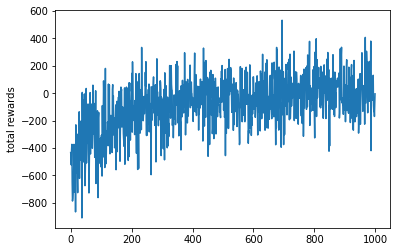

In [ ]:
# Check Convergence by tracking total rewards per episode vs episode number
plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.ylabel("total rewards")
plt.show()

In [ ]:

# Average reward per 100 episode
avg_rewards = []
episodes = len(rewards_per_episode)
index = 0
track_total_reward = 0
for episode_number in range(episodes):
    if index != 100:
        track_total_reward += rewards_per_episode[episode_number]
        index += 1
    else:
        avg_rewards.append(track_total_reward/index)
        track_total_reward = rewards_per_episode[episode_number]
        index = 1

avg_rewards.append(track_total_reward/index)
        
    
print(avg_rewards)

[-376.07, -213.58, -100.86, -82.35, -36.32, -55.05, -28.73, 13.74, 18.86, -2.14]


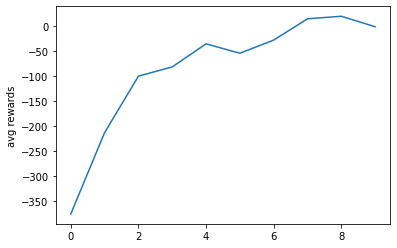

In [ ]:
## Check Convergence by tracking average rewards per episode vs episode number
plt.plot(list(range(len(avg_rewards))), avg_rewards)
plt.ylabel("avg rewards")
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [ ]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

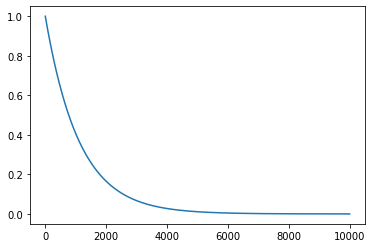

In [ ]:
plt.plot(time, epsilon)
plt.show()